## Problem Set 3
### MACS 30100, Dr. Evans
### Leoson Hoay

**Importing necessary packages:**

In [2]:
import numpy as np
import scipy.stats as sts
import scipy.optimize as opt
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import pandas as pd

### Problem (1) 
**Some income data, lognormal distribution, and GMM.**

**(a)**

<IPython.core.display.Javascript object>


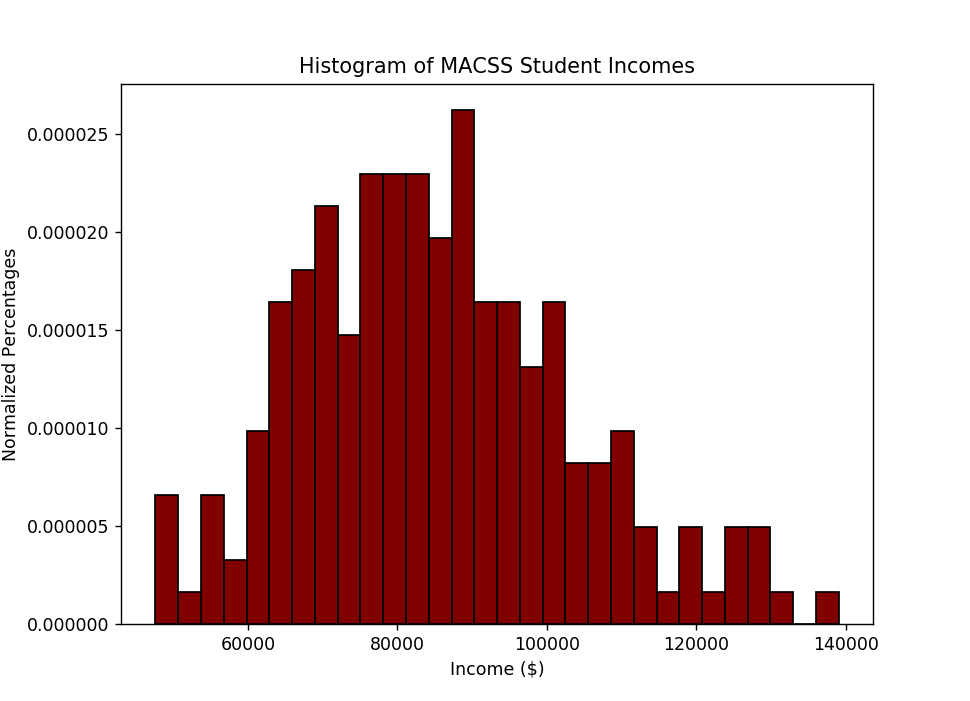

In [7]:
incomes = np.genfromtxt('../../ProblemSets/PS3/incomes.txt')

%matplotlib notebook
count, bins, ignored = plt.hist(incomes, 30, edgecolor='black', color = "maroon", normed=True)
plt.title('Histogram of MACSS Student Incomes')
plt.xlabel('Income (\$)')
plt.ylabel('Normalized Percentages')
plt.show()